In [1]:
#!/usr/bin/env python3
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
from model import *
from visual_functions import *
from sweep_configs import *
from sklearn.model_selection import train_test_split
from wandb.keras import WandbCallback
#from optimization import *
%matplotlib inline

## ---------------------- load data ----------------------------------------
train_dir = "./datasets/train/"
test_dir = "./datasets/test/"

k = 0
displays = np.load(train_dir + "X/X{}.npz".format(k), "r")['arr_0']
displays_test = np.load(test_dir + "X/X{}.npz".format(k), "r")['arr_0']
params = np.load(train_dir + "y/y{}.npz".format(k), "r")['arr_0']
params_test = np.load(test_dir + "y/y{}.npz".format(k), "r")['arr_0']

## Toymodel with new dimensions (72x32)

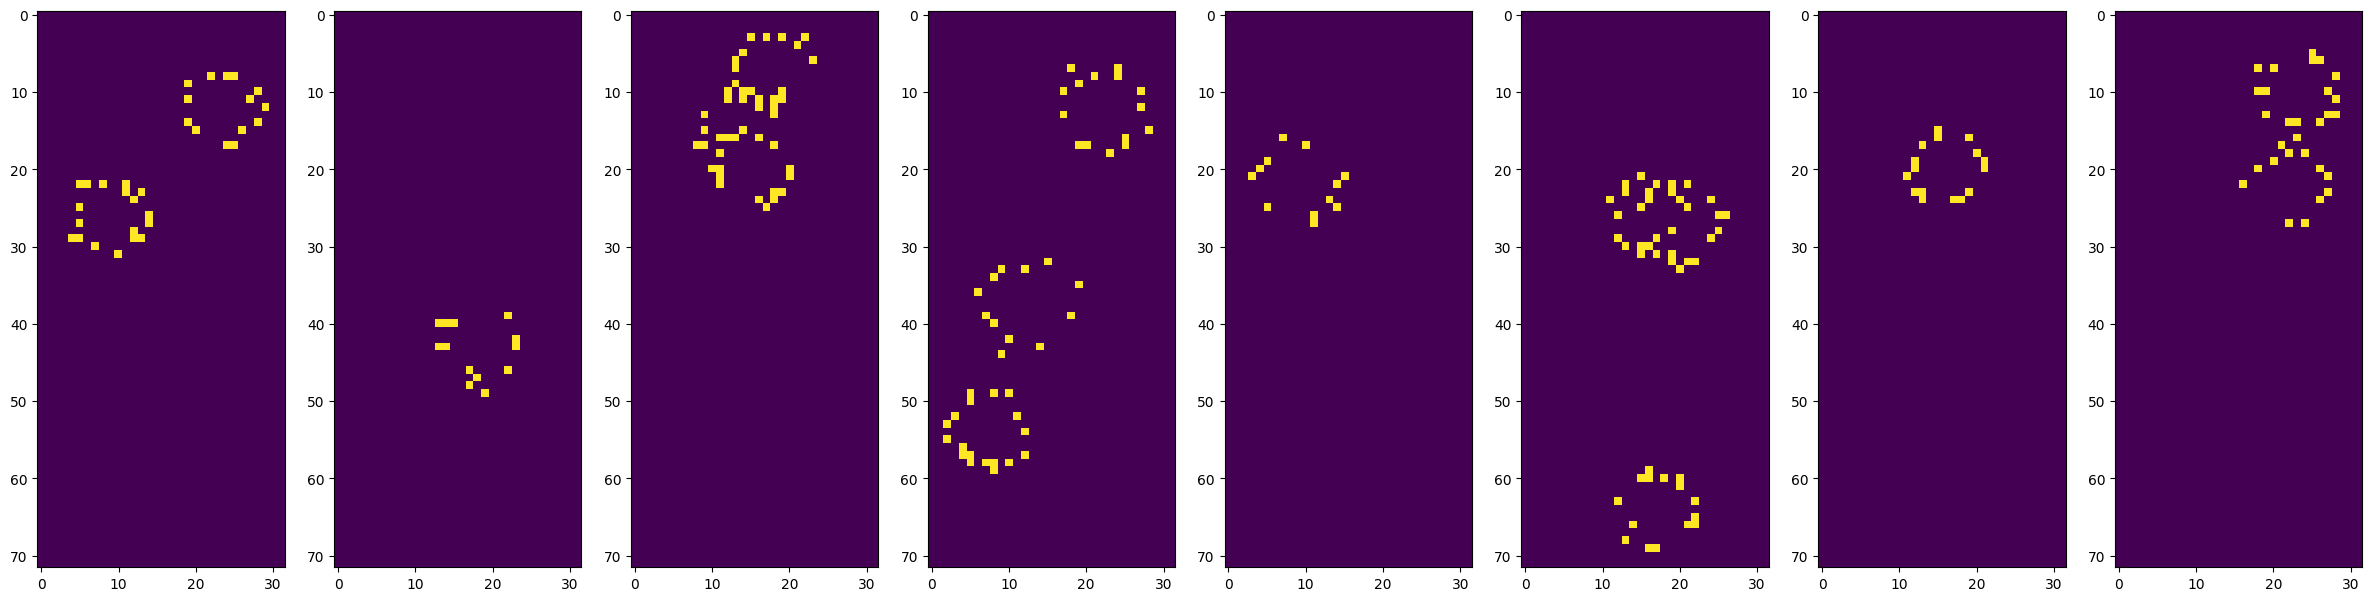

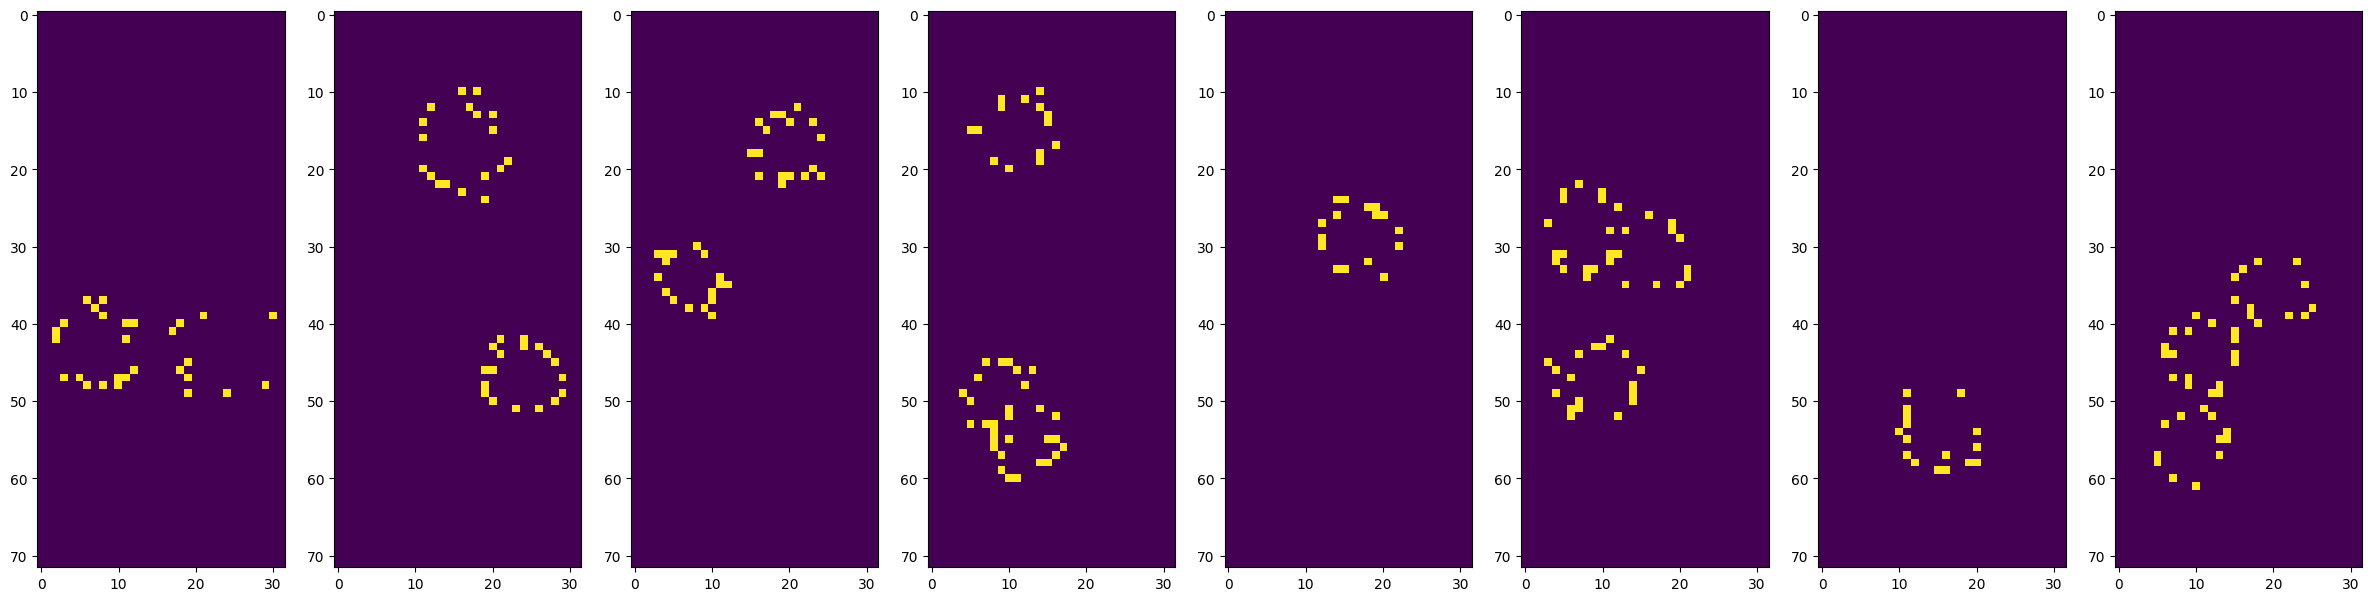

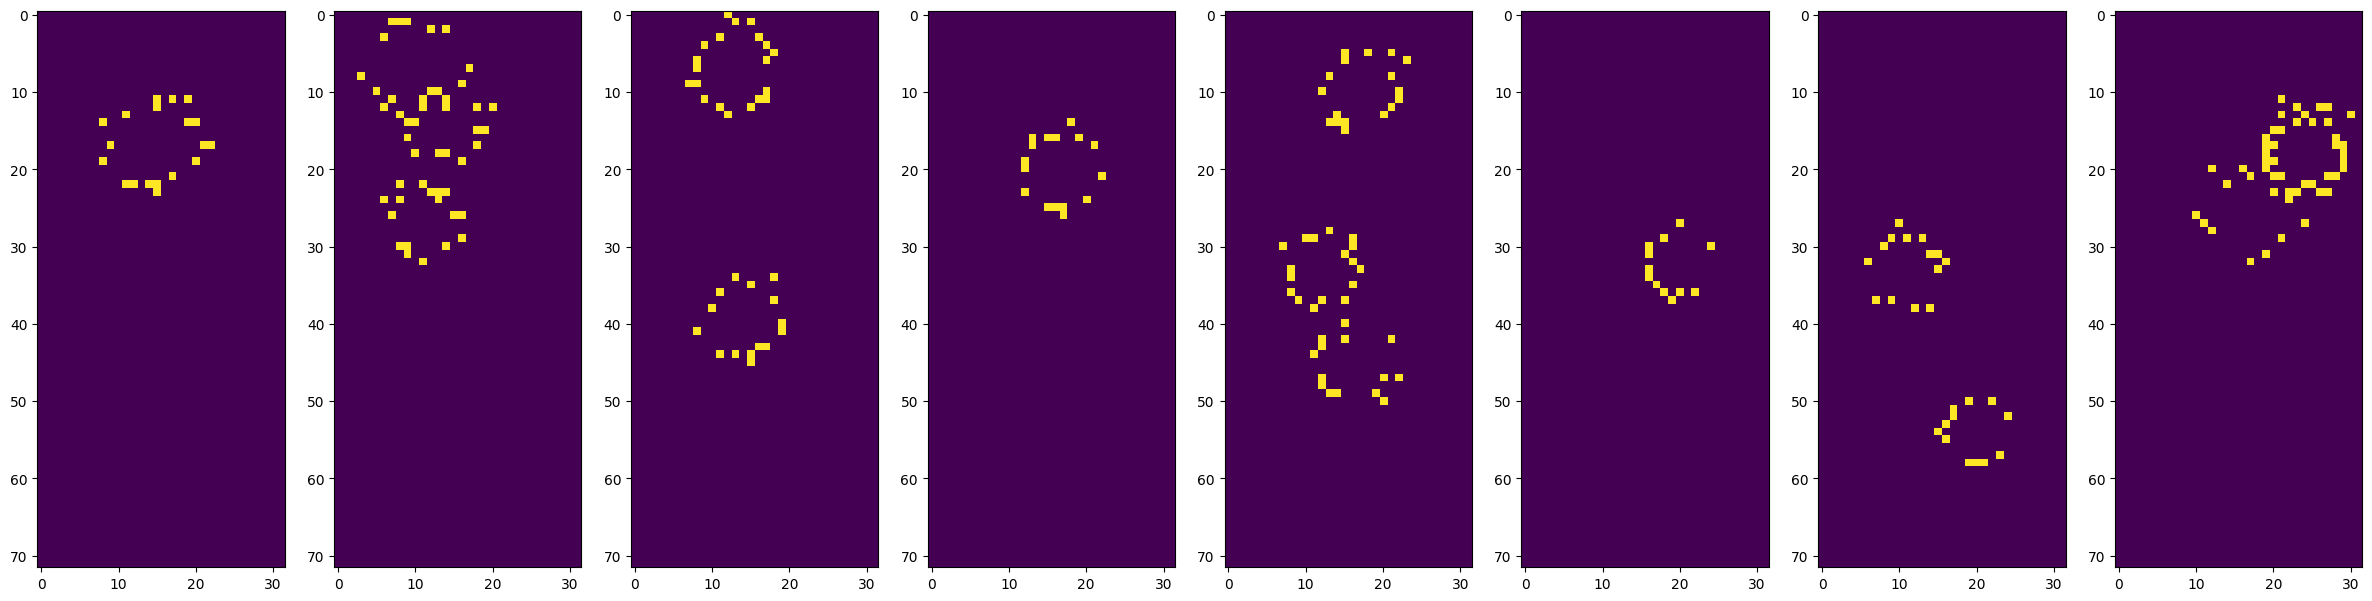

In [5]:
for i in range(3):
    display_data(displays, i)
#    plt.imshow(plot_single_event(displays[i], params[i]))
#    plt.show()

## Real data (mcbm)

In [154]:
# load data file and some preprocessing
def loadDataFile(datafile, pixel_x = 32, pixel_y = 72):
    with open(datafile, 'r') as temp_f:
        col_count = [ len(l.split(",")) for l in temp_f.readlines() ]
    column_names = [i for i in range(0, max(col_count))]
    hits = pd.read_csv(datafile,header=None ,index_col=0,comment='#',
                       delimiter=",", nrows=
                       20000,names=column_names).values.astype('int32')
    hits[hits < 0] = 0
    hits_temp = np.zeros([len(hits[:,0]), pixel_x*pixel_y])
    for i in range(len(hits[:,0])):
        for j in range(len(hits[0,:])):
            if hits[i,j]==0:
                break
            hits_temp[i,hits[i,j]-1]+=1
    hits_temp = tf.reshape(hits_temp, [len(hits[:,0]), pixel_y, pixel_x])
    hits_temp = tf.clip_by_value(hits_temp, clip_value_min=0., clip_value_max=1.)
    hits = tf.cast(hits_temp[..., tf.newaxis],dtype=tf.float32)
    print('load data from  ' + datafile + '  -> ' + str(len(hits[:])) + '  events loaded' )
    return hits


In [20]:
#hits_real = loadDataFile("hits_real.txt")
#for i in range(1):
#    display_data(hits_real, i)

## Simulation data (mcbm)

load data from  hits_true.txt  -> 20000  events loaded


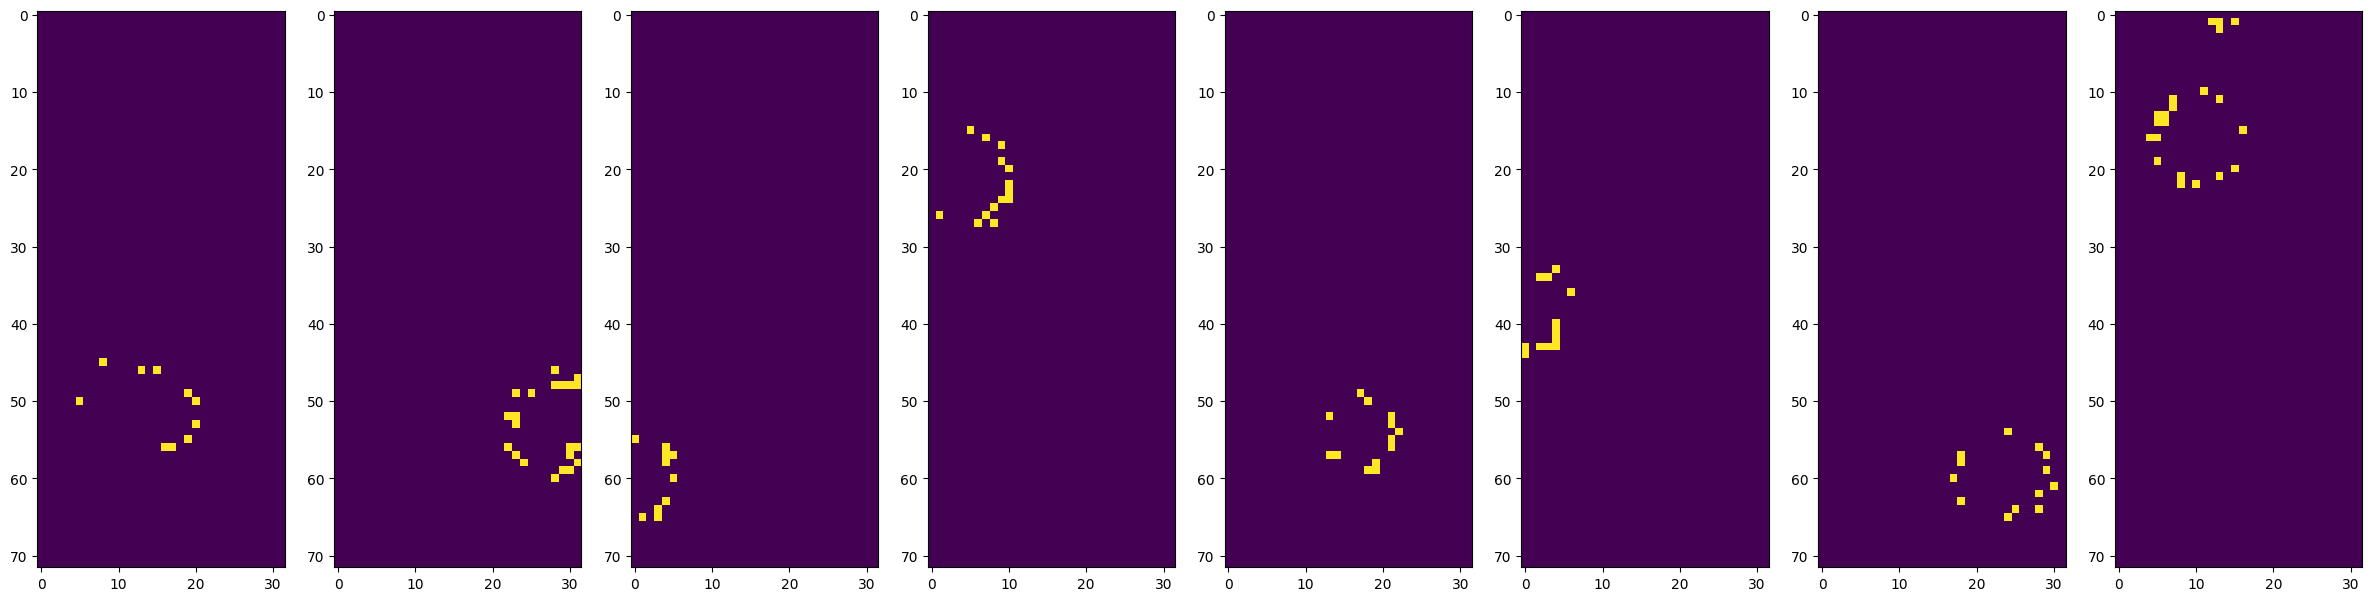

In [155]:
hits_true = loadDataFile("hits_true.txt")
for i in range(1):
    display_data(hits_true, i)

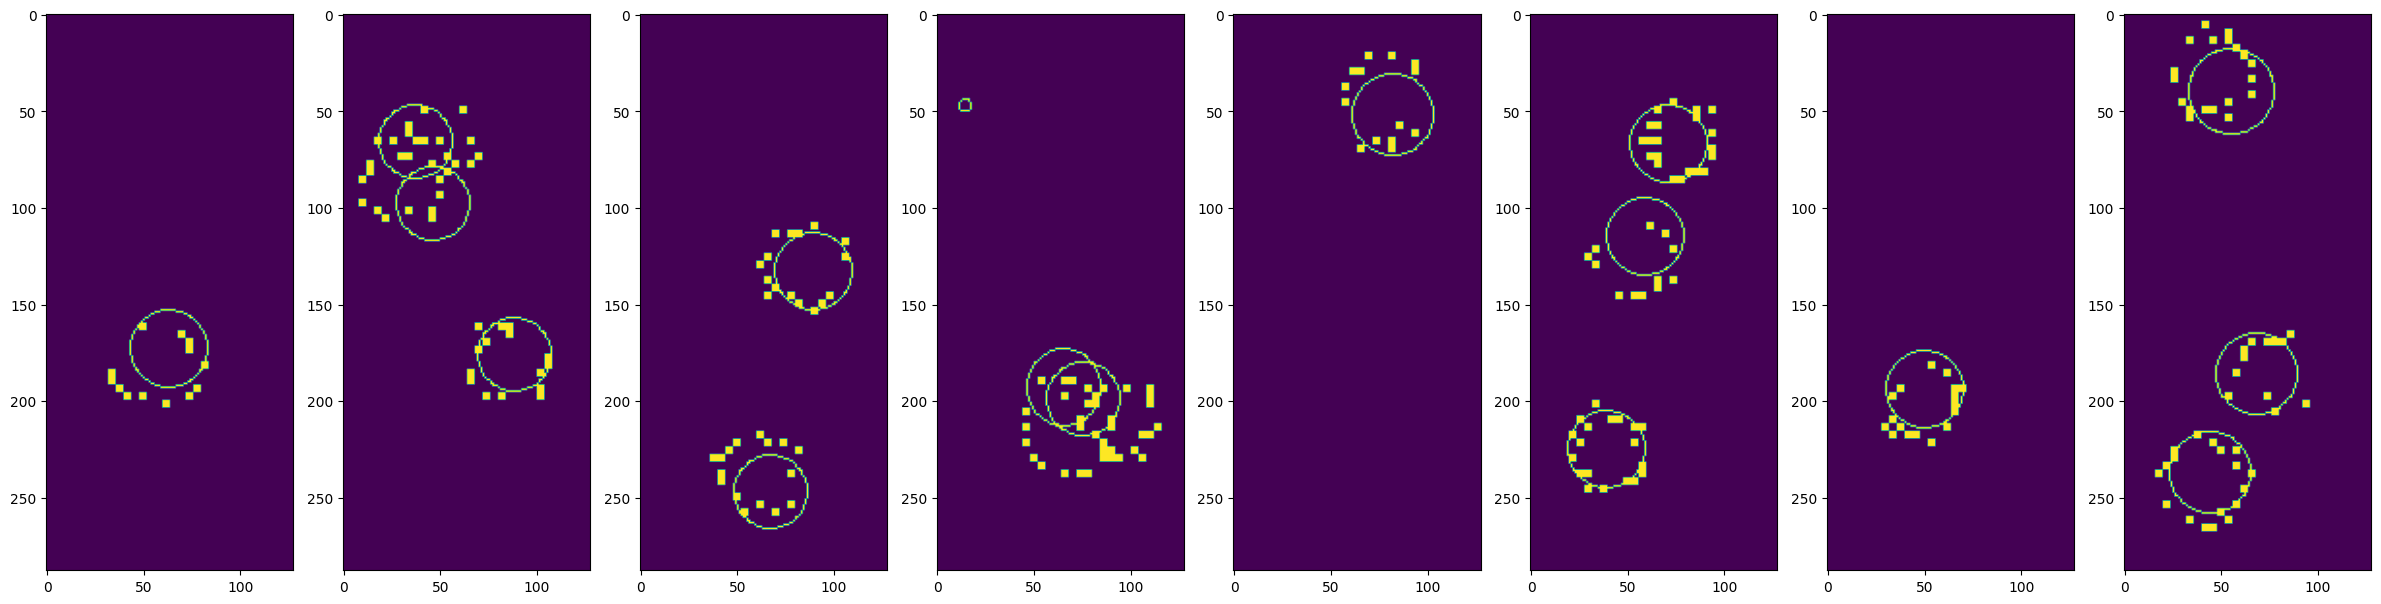

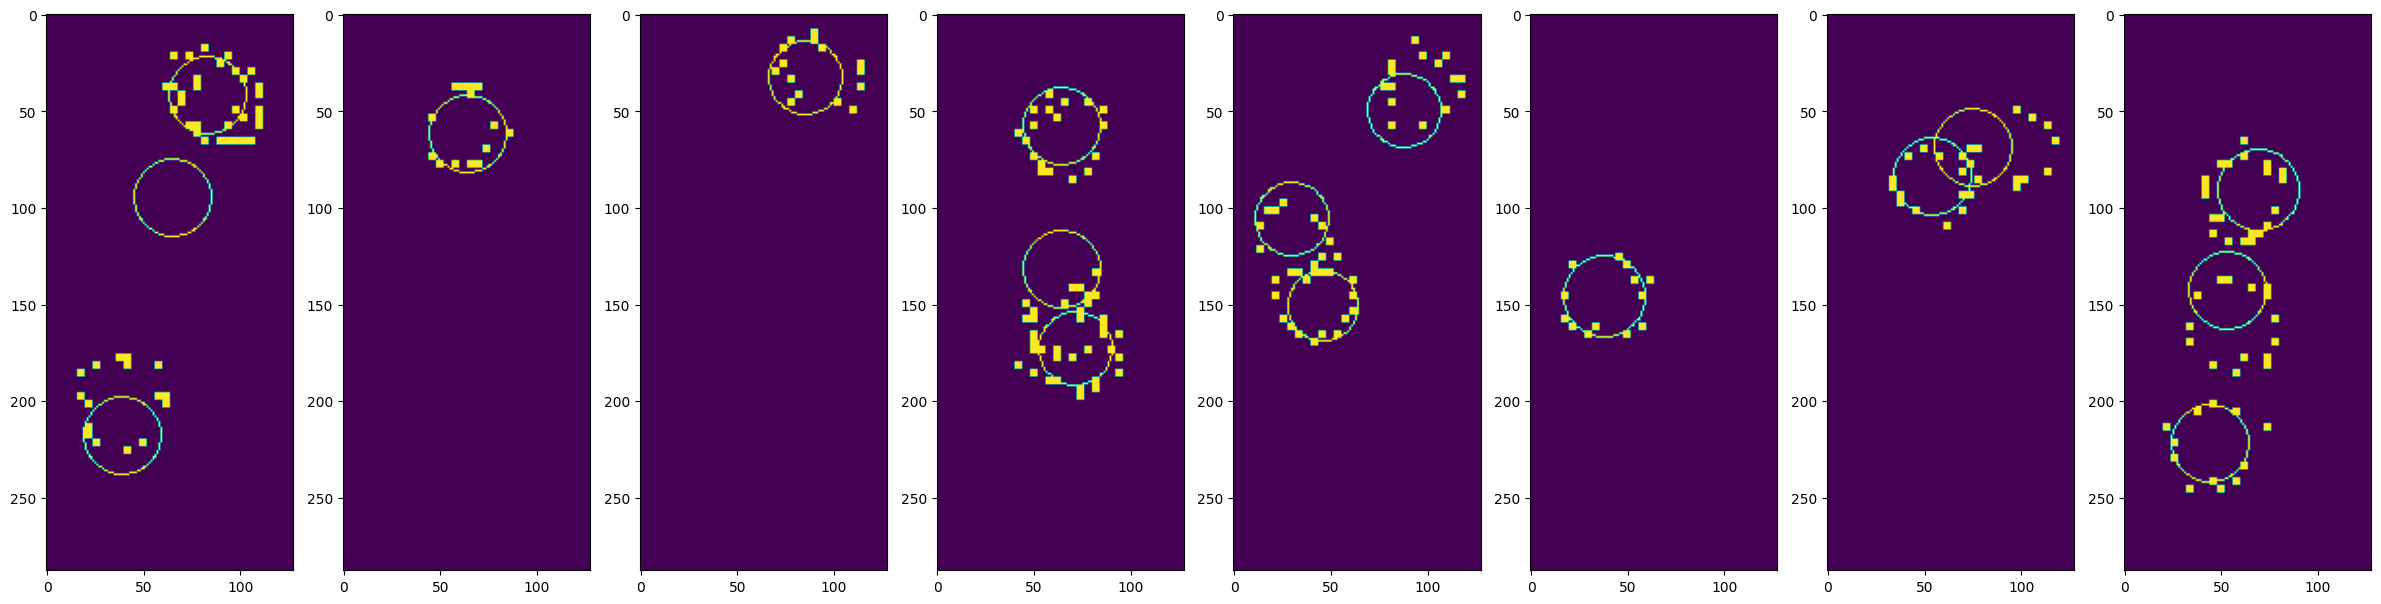

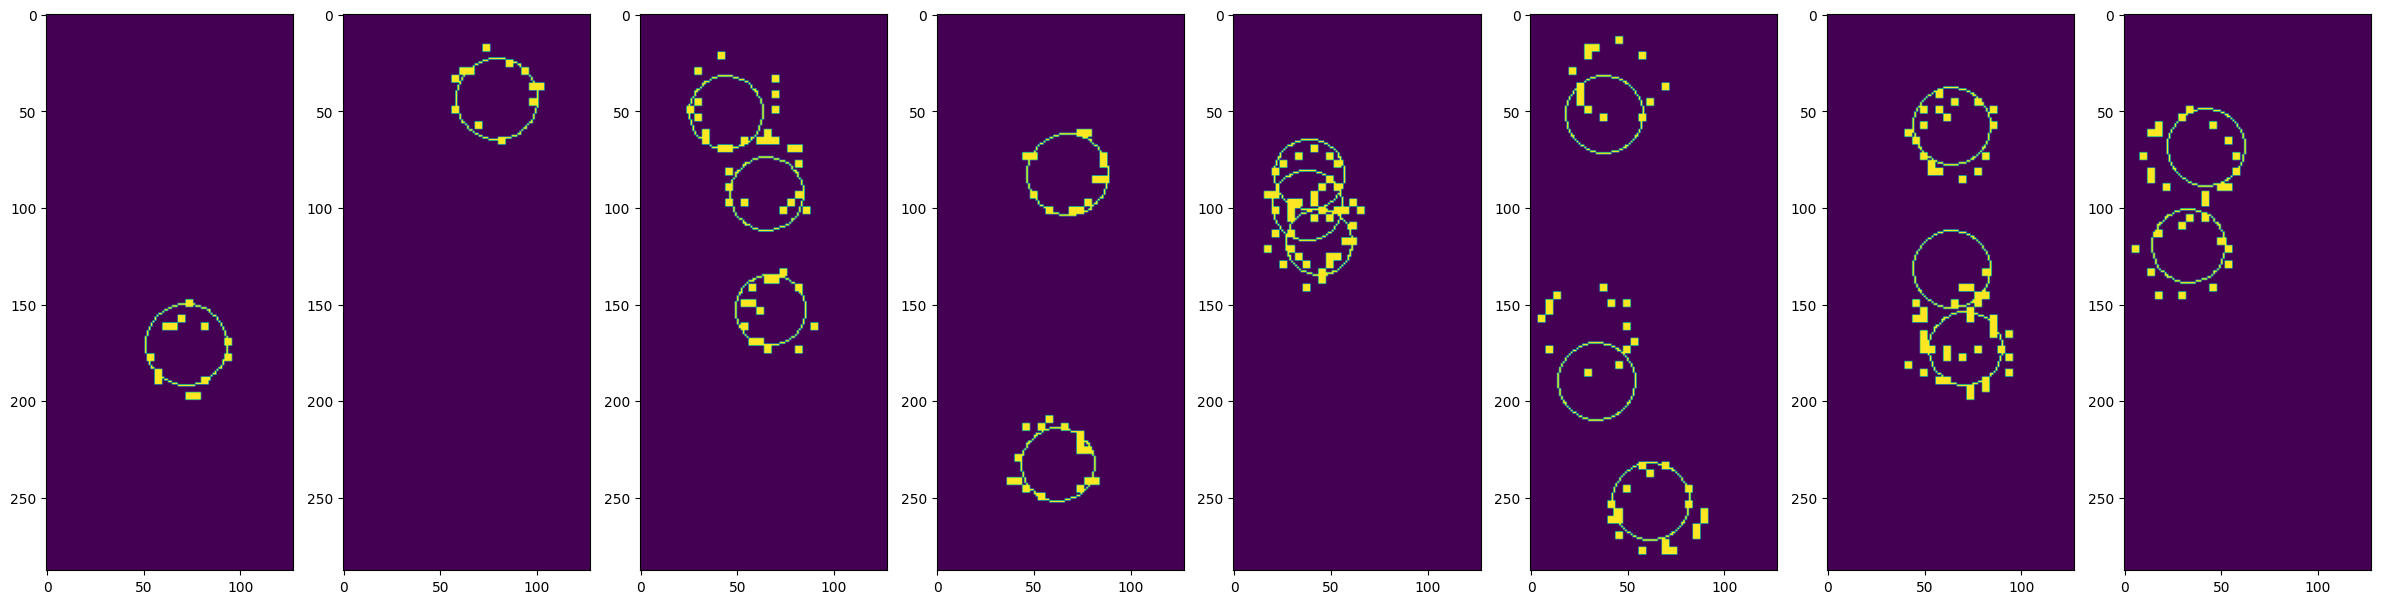

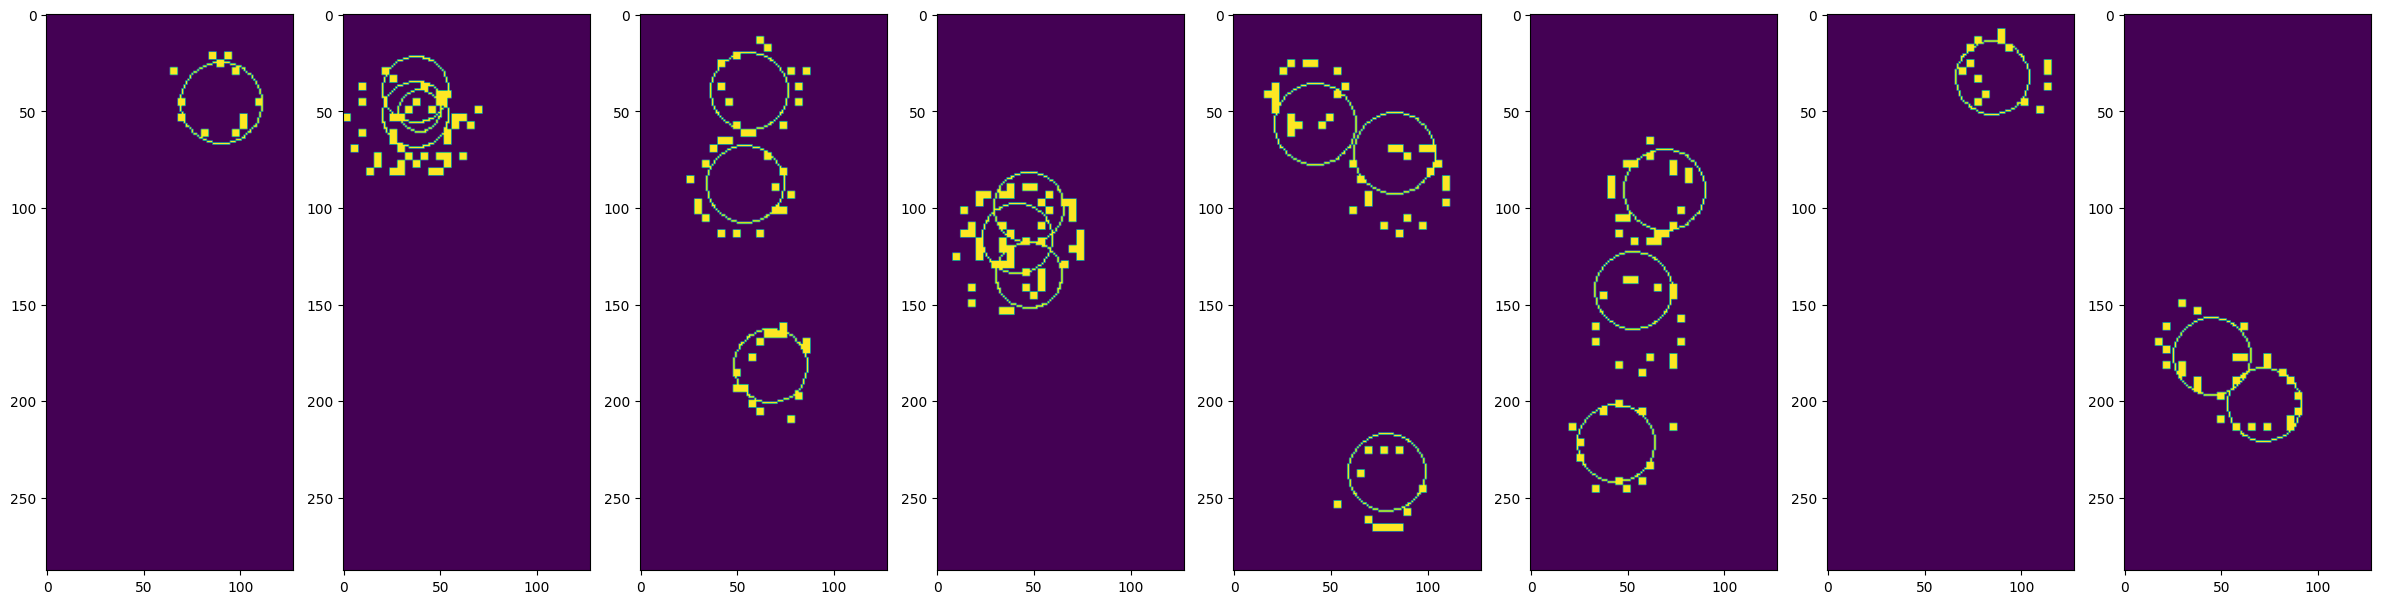

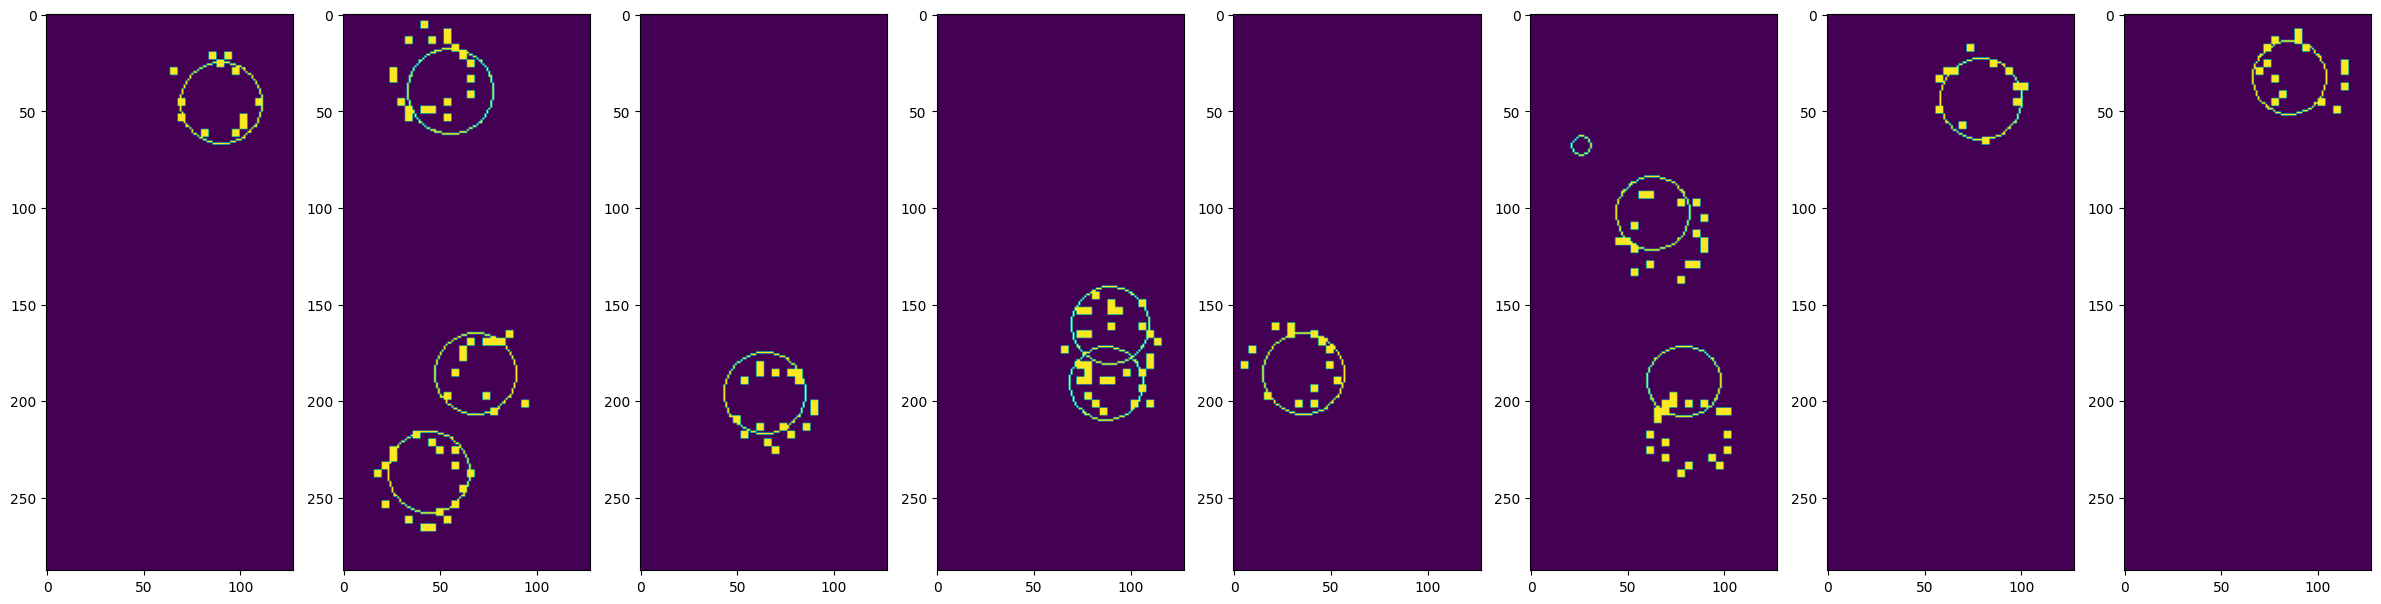

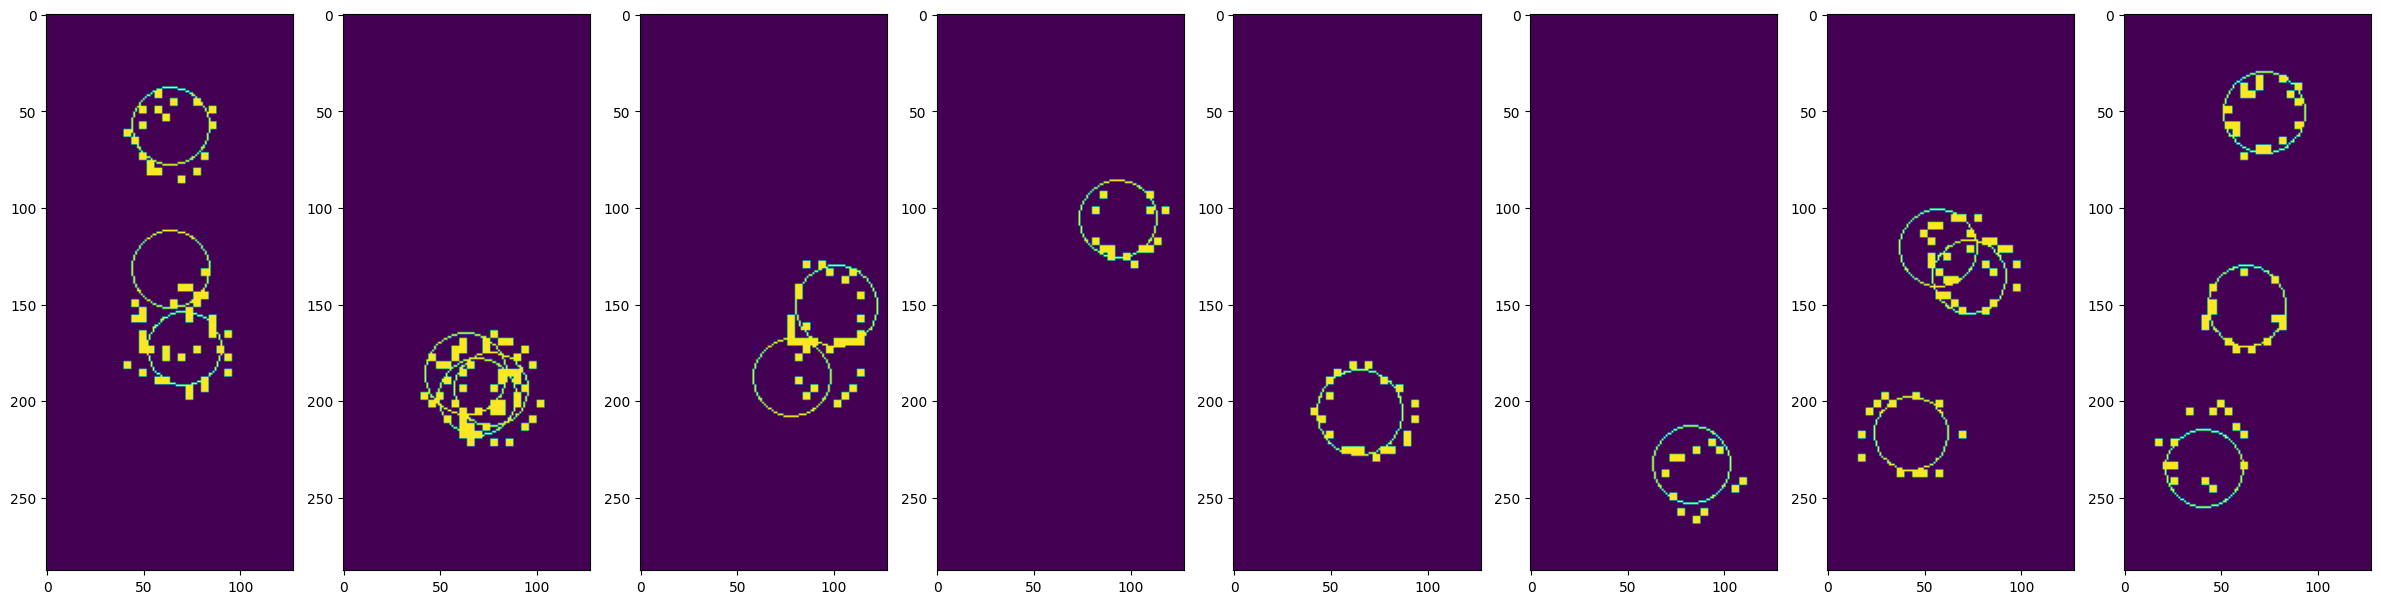

In [6]:
model = tf.keras.models.load_model("models/test_wo_flip-CNN-mcbm.model")
for i in range(6):
#    show_predict(np.array(hits_true[:100]), model, i)#, "fig{}".format(i))
    show_predict(displays_test, model, i)#, "fig{}".format(i))